# Xarray demonstration

Calculating the min, max, mean, median geopotential height for each day during an atmospheric blocking event.

### Requirements ID Number: GPD.2

#### As a developer, I need to calculate the mean, median, min and max geopotential height data for each day during the time period of a known atmospheric blocking event (May 24-31, 2023) to visualize the data in a time series showing the evolution of the blocked flow at 500 hPa.

#### Acceptance Criteria

1. Must use geopotential height data in a NetCDF file
2. Data must include Latitudes and longitude
3. Time period should be from May 24-31, 2023
3. Temporal data must be in datetime format
4. Calculations must include min, max, mean, and median statistics for the geopotential height
5. Xarray should output data plottable using cartopy

#### Research 

1. Creating new xarray datasets from variables calculated from an existing xarray
2. Cartopy plotting

#### Testing

1. Getting a reasonable plot of the the xarray data that shows a time series evolution of an atmospheric blocking event

# Import necessary packages

In [50]:
import xarray as xr
import numpy as np

# Load the NetCDF dataset into the notebook

In [51]:
data = xr.open_dataset('8cbccc6f57bac9ec68c2fbf3998150b7.nc')

#print the dataset to inspect variable
print(data)

<xarray.Dataset>
Dimensions:         (valid_time: 32, pressure_level: 1, latitude: 109,
                     longitude: 89)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2023-05-24 ... 2023-05-31T18:...
  * pressure_level  (pressure_level) float64 500.0
  * latitude        (latitude) float64 50.0 49.75 49.5 49.25 ... 23.5 23.25 23.0
  * longitude       (longitude) float64 -105.5 -105.2 -105.0 ... -83.75 -83.5
Data variables:
    number          int64 ...
    expver          (valid_time) object ...
    z               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-26T13:34 GRIB to CDM+CF via cfgrib-0.9.1...


# Access/calculate the geopotential height at 500 hPa

In [58]:
# variable in ERA5 dataset is geopotential, rather than geopotential height. To calculate the geopotential height from our accessed variable, just divide the 'z' data by gravitational accleration
g = 9.80665  #m/s^2
geopot_hgt = data['z']/g  # gives us geopotential height in meters

# Group data by day

In [59]:
# Dataset has four times per day (0, 6, 12, 18) so use groupby to aggregate those times for each day to calculate the statistics for the days
daily_group = geopot_hgt.groupby('valid_time.day')


# Calculate the min, max, mean, and median for each day in time period

In [60]:
# calculate the statistics for each day
min_day = daily_group.min()
max_day = daily_group.max()
mean_day = daily_group.mean()
median_day = daily_group.median()

# put all calculated into the same xarray; rename variables to handle the merge/avoid overwriting variables
daily_stats = xr.merge([min_day.rename('day_min'), max_day.rename('day_max'), mean_day.rename('day_mean'),median_day.rename('day_median')])

print(daily_stats)

<xarray.Dataset>
Dimensions:         (pressure_level: 1, latitude: 109, longitude: 89, day: 8)
Coordinates:
  * pressure_level  (pressure_level) float64 500.0
  * latitude        (latitude) float64 50.0 49.75 49.5 49.25 ... 23.5 23.25 23.0
  * longitude       (longitude) float64 -105.5 -105.2 -105.0 ... -83.75 -83.5
  * day             (day) int64 24 25 26 27 28 29 30 31
Data variables:
    day_min         (day, pressure_level, latitude, longitude) float32 5.762e...
    day_max         (day, pressure_level, latitude, longitude) float32 5.781e...
    day_mean        (day, pressure_level, latitude, longitude) float32 5.773e...
    day_median      (day, pressure_level, latitude, longitude) float32 5.774e...


# Plot the daily stats on a time series to test that the xarray caluclations worked

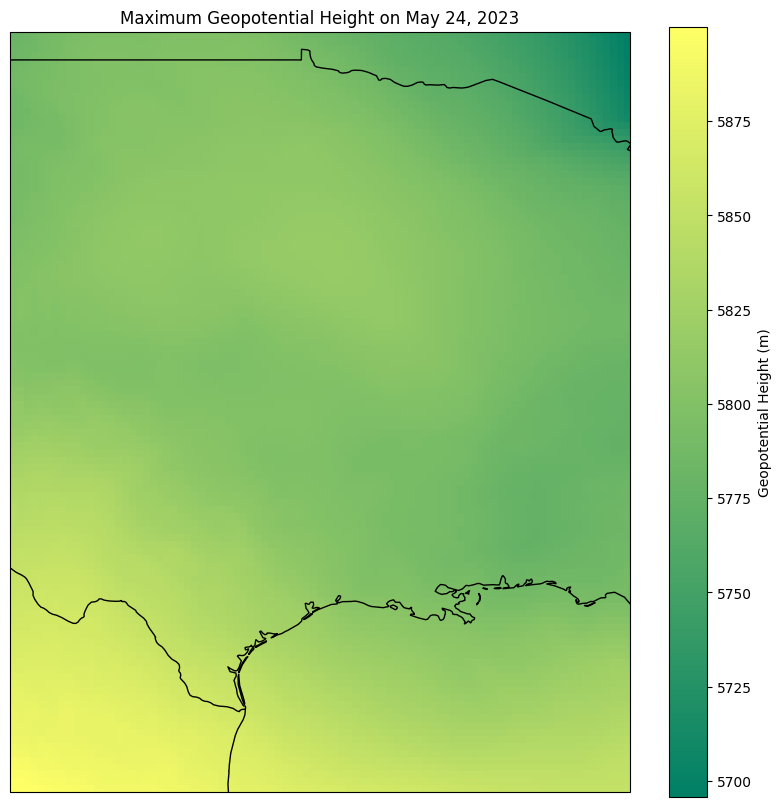

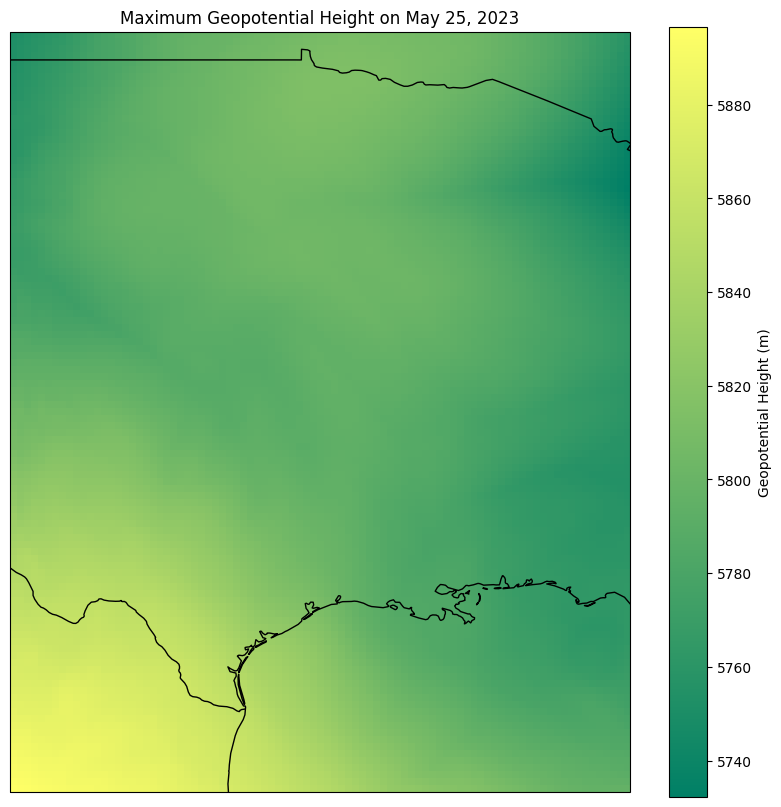

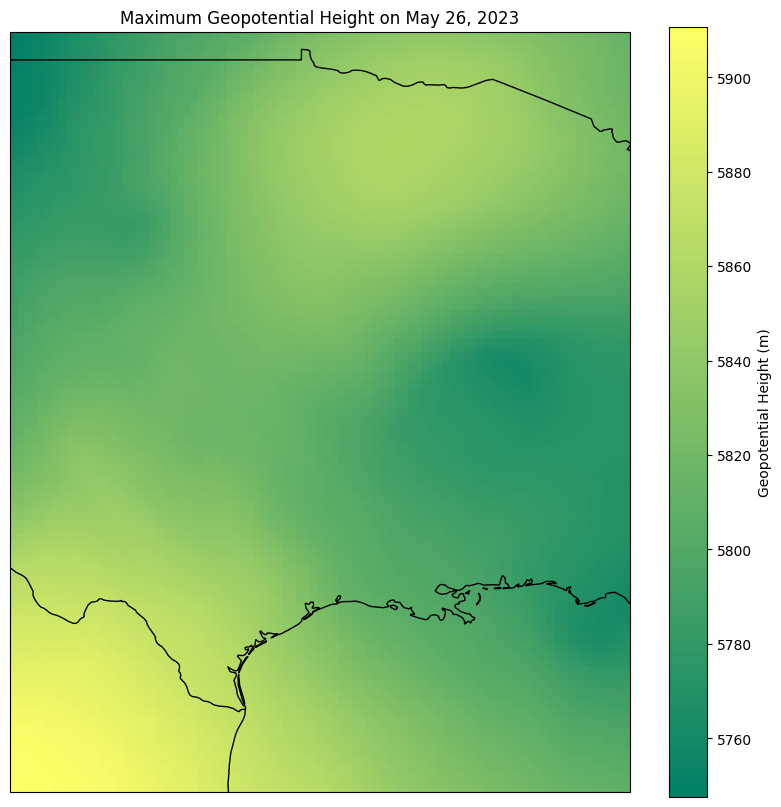

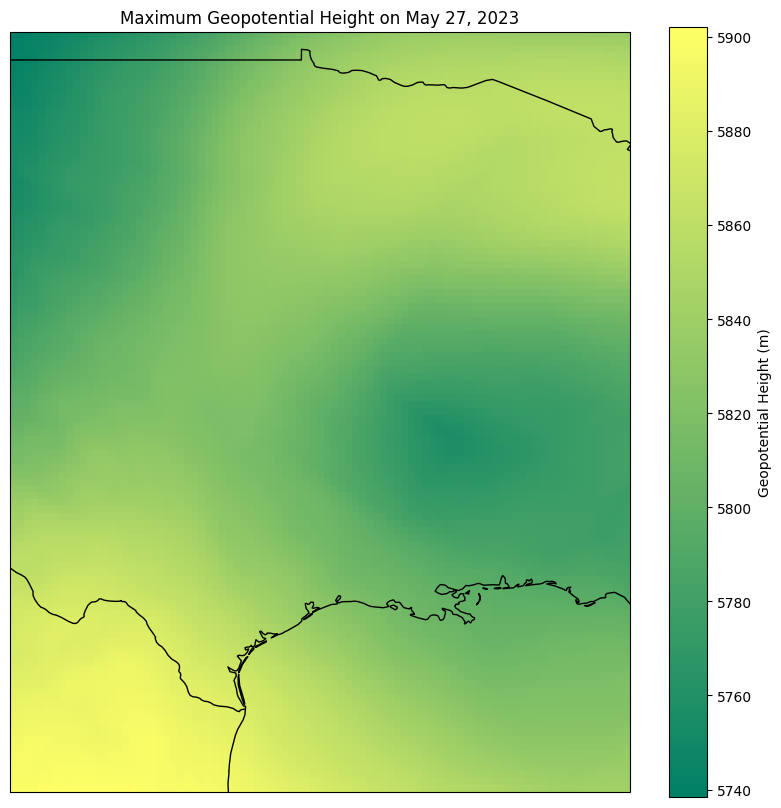

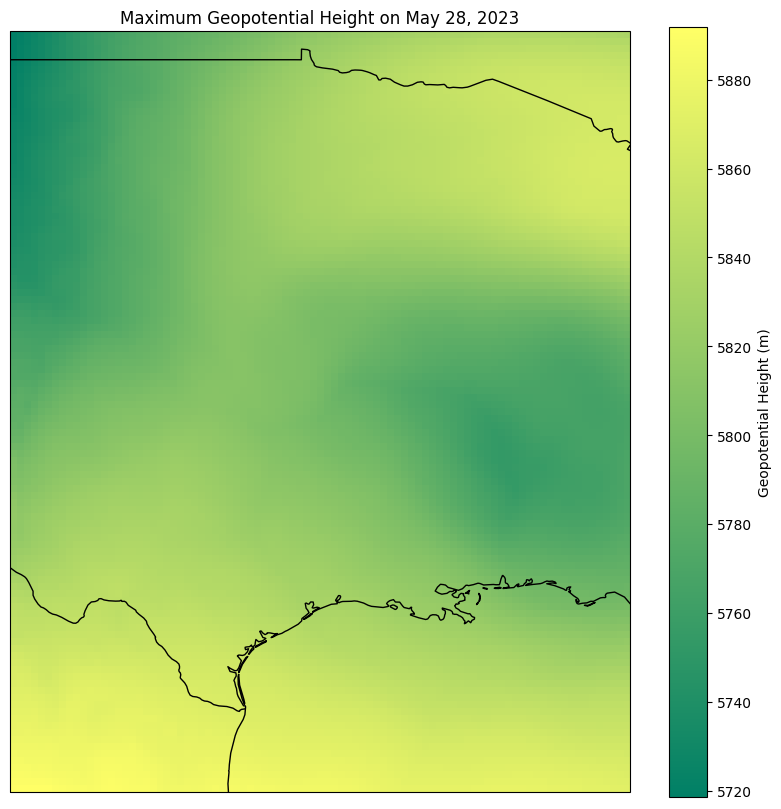

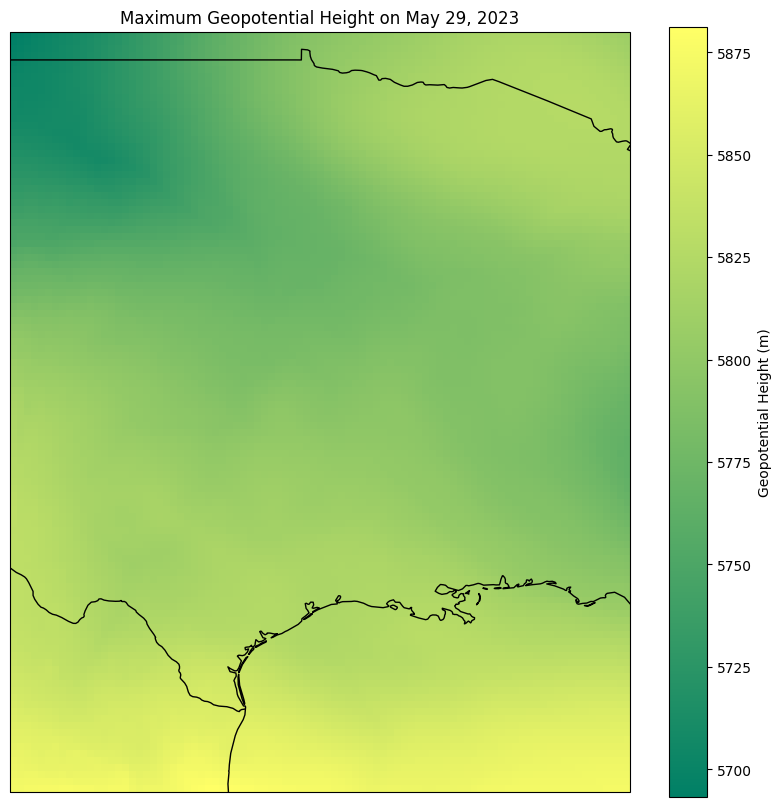

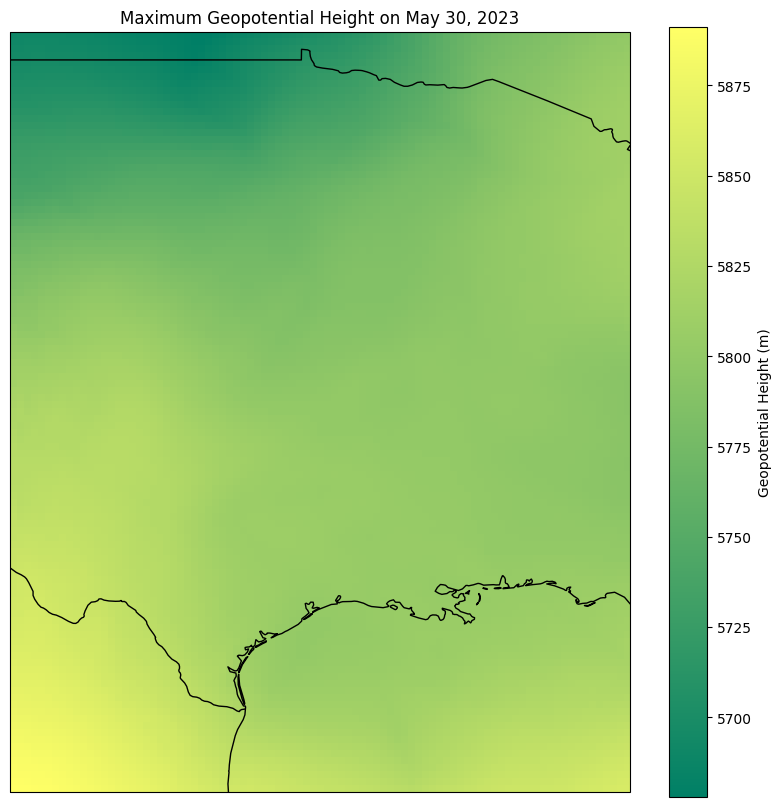

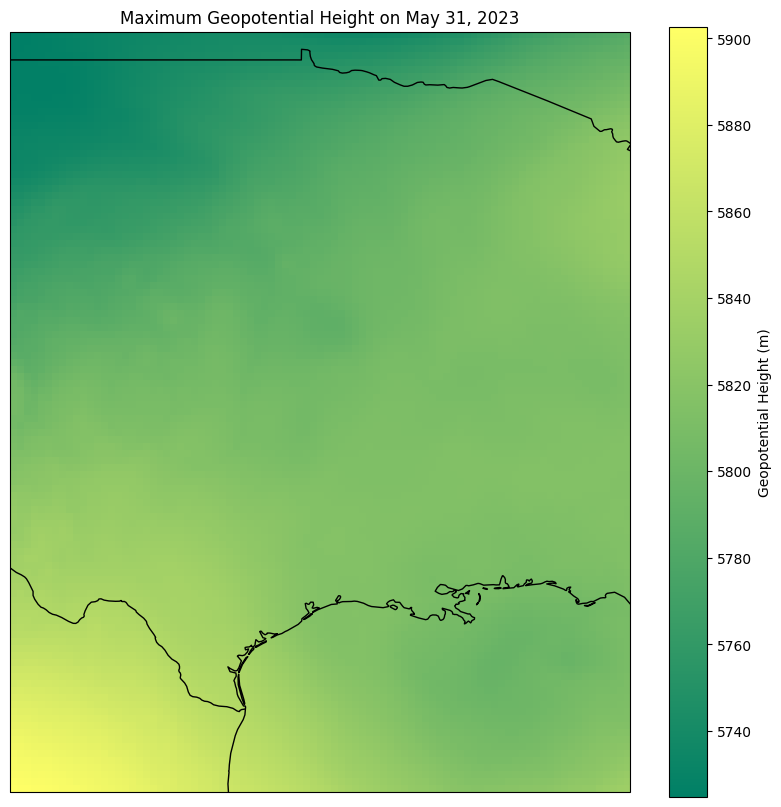

In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# set the varibale (max) we will test
day_max = daily_stats['day_max']

# loop and iterate through the day_max dataset values while using index (i) for each day in the time period
for i, day in enumerate(day_max['day'].values):
    
    # select max daily data for each index and day
    max_data = day_max.isel(day=i)
    # converts values from max_data into 2D array by removing the first dimension ot be able to visualize the data in 2D map
    max_data_2d = max_data.values.squeeze()

    # create figure to plot data; sets figure size and axis projection to PlateCarree
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # image to display the max data in 2D form, with an extent being the lat and lon boundaries of the region of interest, with it plotted using PlateCarree projection
    im = ax.imshow(max_data_2d, cmap='summer', extent=[day_max.longitude.min(), day_max.longitude.max(), day_max.latitude.min(), day_max.latitude.max()], transform=ccrs.PlateCarree())
    
    #add plot features
    plt.colorbar(im, label='Geopotential Height (m)')
    plt.title(f'Maximum Geopotential Height on May {day}, 2023')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # add borders and coastlines to give spatial context
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor='black')
    
    plt.show()
